In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
import torchaudio
from sp4asc.datasets.dcase import DCaseDataset
import librosa
import librosa.display
import pandas as pd
from torch.utils.data import Dataset
%matplotlib inline

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


### Gros Neural Network

In [19]:
%mkdir data
%cd data
!wget 
!tar -zxvf .tgz

c:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE\data


Un sous-r�pertoire ou un fichier data existe d�j�.
'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'tar' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [4]:
%ls

 Le volume dans le lecteur C s'appelle OS
 Le num�ro de s�rie du volume est 7475-2230

 R�pertoire de c:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE\data

01/03/2022  16:38    <DIR>          .
01/03/2022  16:38    <DIR>          ..
               0 fichier(s)                0 octets
               2 R�p(s)  16�794�103�808 octets libres


In [ ]:
%cd 
%ls

#### Data Processing



In [5]:
%cd ..
data_dir = '/data'

c:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE


### Creating ResNet model

In [6]:
model_resnet = models.resnet50(pretrained=False)

In [7]:
model_resnet.fc = torch.nn.Linear(in_features=2048,out_features=10)

In [8]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Data Extraction

In [33]:
%ls

 Le volume dans le lecteur C s'appelle OS
 Le num�ro de s�rie du volume est 7475-2230

 R�pertoire de c:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE

01/03/2022  16:38    <DIR>          .
01/03/2022  16:38    <DIR>          ..
01/03/2022  16:29    <DIR>          configs
01/03/2022  17:11    <DIR>          data
01/03/2022  16:29               827 Dockerfile
01/03/2022  16:29            10�339 LICENSE
01/03/2022  17:11            19�654 projet.ipynb
01/03/2022  16:29             8�166 README.md
01/03/2022  16:29               118 setup.py
01/03/2022  16:45    <DIR>          sp4asc
01/03/2022  16:29             2�838 test.py
01/03/2022  16:29             3�143 train.py
01/03/2022  16:29    <DIR>          trained_models
               7 fichier(s)           45�085 octets
               6 R�p(s)   8�944�226�304 octets libres


In [78]:
def get_audio(file):
    signal, sample_rate = librosa.load(file, sr= 22050) 

def draw_signal(signal):
    FIG_SIZE = (15,4)
    plt.figure(figsize=FIG_SIZE)
    librosa.display.waveshow(signal, sample_rate, alpha=0.4)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform")

    # FFT -> power spectrum
    # perform Fourier transform
    fft = np.fft.fft(signal)

    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)

    # create frequency variable
    f = np.linspace(0, sample_rate, len(spectrum))

    # take half of the spectrum and frequency
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]

    # plot spectrum
    plt.figure(figsize=FIG_SIZE)
    plt.plot(left_f, left_spectrum, alpha=0.4)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Power spectrum")


In [53]:
import os

root_dir = "data/TAU-urban-acoustic-scenes-2020-mobile-development"
files = os.listdir(root_dir + '/audio')
files = [[file] + file.replace('.wav','').split('-',5) for file in files]
df_files = pd.DataFrame(files,columns=['file_name','label_name','city','location_id','segment_id','device_id'])
df_files.to_csv(root_dir + '/train_data.csv',index=False)

In [74]:
# dataloader 


class Dataloader(Dataset):
    labelind2name = {
        0: "airport",
        1: "bus",
        2: "metro",
        3: "metro_station",
        4: "park",
        5: "public_square",
        6: "shopping_mall",
        7: "street_pedestrian",
        8: "street_traffic",
        9: "tram",
    }
    name2labelind = {
        "airport": 0,
        "bus": 1,
        "metro": 2,
        "metro_station": 3,
        "park": 4,
        "public_square": 5,
        "shopping_mall": 6,
        "street_pedestrian": 7,
        "street_traffic": 8,
        "tram": 9,
    }

    def __init__(self,root_dir,split):
        self.root_dir = root_dir
        self.split = split
        if split== "train":
            csv_path = root_dir + "/train_data.csv"

        elif split == "val":
            csv_path = root_dir + "/val_data.csv"
        elif split == "test":
            csv_path = root_dir + "/test_data.csv"
        else:
            raise ValueError("Split not implemented")

        csvData = pd.read_csv(csv_path, sep=",")
        # In test mode, just get file list
        if split == "test":
            self.file_names = []
            for i in range(0, len(csvData)):
                self.file_names.append(csvData.iloc[i, 0])
            return

        self.file_names, self.labels,self.devices = [], [],[]

        for i in range(0, len(csvData)):
            self.file_names.append(csvData.iloc[i, 0])
            self.labels.append(csvData.iloc[i, 1])
            self.devices.append(csvData.iloc[i,5])

        # Transform class name to index
        self.labels = [self.name2labelind[name] for name in self.labels]

        


    def __getitem__(self,index):
       # Load data
        filepath = self.root_dir + '/audio/' + self.file_names[index]
        sound, sfreq = torchaudio.load(filepath)
        assert sound.shape[0] == 1, "Expected mono channel"
        sound = torch.mean(sound, dim=0)
        assert sfreq == 44100, "Expected sampling rate of 44.1 kHz"

        # Remove last samples if longer than expected
        if sound.shape[-1] >= 441000:
            sound = sound[:441000]

        if self.split == "test":
            return sound, 255, self.file_names[index], "unknown"
        else:
            return (
                sound,
                self.labels[index],
                self.file_names[index],
                self.devices[index],
            )


In [75]:
train_dataset = Dataloader(
    root_dir="data/TAU-urban-acoustic-scenes-2020-mobile-development",
    split = 'train'
)


In [76]:
train_dataset[3]

(tensor([ 0.0000e+00, -3.0518e-05, -3.0518e-05,  ..., -9.1553e-05,
         -8.3314e-03, -1.2665e-02]),
 0,
 'airport-barcelona-0-10-s4.wav',
 's4')

C:\Users\STANIS~1\AppData\Local\Temp/ipykernel_109560/1608631841.py:7: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sample_rate, alpha=0.4)


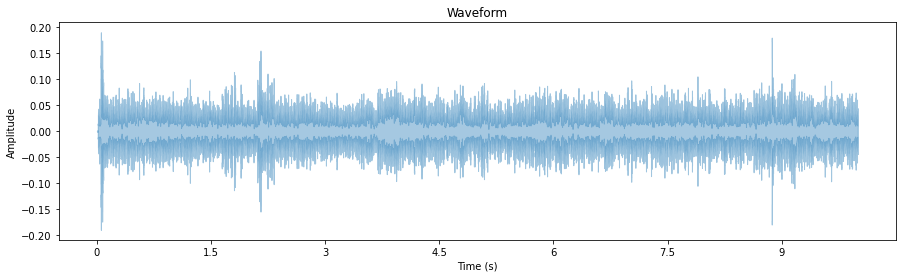

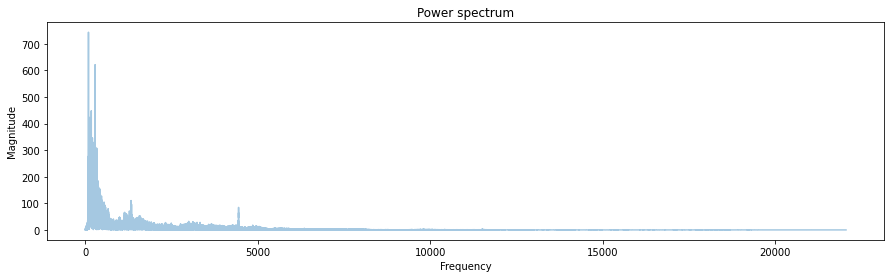

In [80]:
draw_signal(train_dataset[3][0].numpy())

In [13]:
file = r"C:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE\data\TAU-urban-acoustic-scenes-2020-mobile-development\audio\airport-paris-206-6247-b.wav"
signal, sample_rate = librosa.load(file, sr=22050)

In [14]:
signal.shape

(441000,)